In [1]:
import pandas as pd
file_path = "../../data/final_data.csv"
df = pd.read_csv(file_path)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트
malgun = "C:/Windows/Fonts/malgun.ttf"
malgun_name = fm.FontProperties(fname=malgun).get_name()

# 폰트 설정: 한글용 → 기호용 순서대로
plt.rcParams['font.family'] = [malgun_name, 'Segoe UI Symbol']
plt.rcParams['axes.unicode_minus'] = False


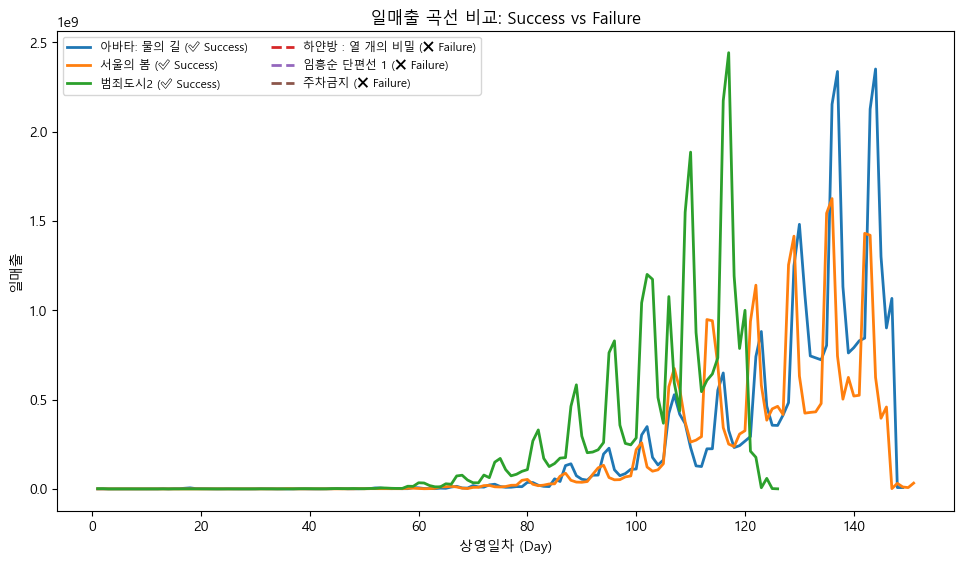

In [12]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# (0) df 로드 가정
# df = pd.read_csv("your_data.csv")

# (1) 한글/특수 기호 폰트 설정
malgun_path = "C:/Windows/Fonts/malgun.ttf"
malgun_name = fm.FontProperties(fname=malgun_path).get_name()
plt.rcParams['font.family']        = [malgun_name, 'Segoe UI Symbol']
plt.rcParams['axes.unicode_minus'] = False

# (2) 상위 3개·하위 3개 영화만 먼저 선택
df_sorted = df.sort_values('total_revenue', ascending=False).reset_index(drop=True)
indices   = list(range(3)) + list(range(len(df_sorted)-3, len(df_sorted)))
selection = df_sorted.loc[indices].copy()

# (3) daily_revenue 파싱
selection['daily_revenue_list'] = selection['daily_revenue'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# (4) 파싱 후, 리스트가 아닌 것은 강제 리스트화
selection['daily_revenue_list'] = selection['daily_revenue_list'].apply(
    lambda x: x if isinstance(x, (list, tuple)) else [x]
)

# (5) day_index 생성
selection['day_index'] = selection['daily_revenue_list'].apply(
    lambda lst: list(range(1, len(lst) + 1))
)

# (6) 플롯
plt.figure(figsize=(10,6))
for idx, row in selection.iterrows():
    is_success = idx < 3  # 처음 3개는 top3
    style      = '-' if is_success else '--'
    tag        = '✅ Success' if is_success else '❌ Failure'
    plt.plot(
        row['day_index'],
        row['daily_revenue_list'],
        linestyle=style,
        linewidth=2,
        label=f"{row['movie']} ({tag})"
    )

plt.title("일매출 곡선 비교: Success vs Failure")
plt.xlabel("상영일차 (Day)")
plt.ylabel("일매출")
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout(pad=2.0)
plt.show()


✅ Success (Top 3): ['아바타: 물의 길', '서울의 봄', '범죄도시2']
❌ Failure (Bottom 3): ['2023 아프리카영화제: 소년들의 거짓말+가나단편선', 'SBFF2021 성북시퀀스1', 'SBFF2021 성북시퀀스2']


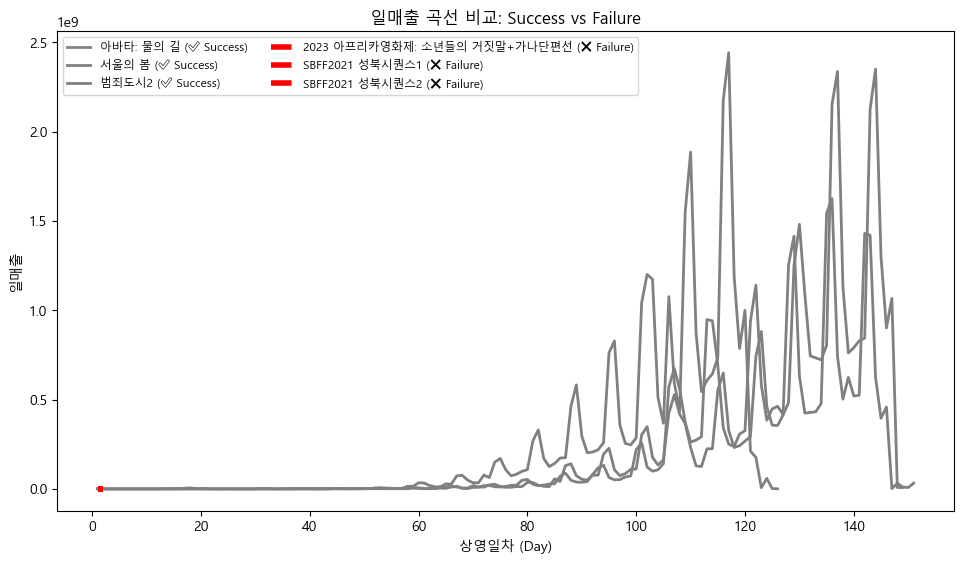

In [18]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# — 0) 한글/기호 폰트 설정 (윈도우 환경) —
malgun_path = "C:/Windows/Fonts/malgun.ttf"
malgun_name = fm.FontProperties(fname=malgun_path).get_name()
plt.rcParams['font.family']        = [malgun_name, 'Segoe UI Symbol']
plt.rcParams['axes.unicode_minus'] = False

# — 1) 성공작·실패작 영화명 추출 —
top3     = df.nlargest(3, 'total_revenue')['movie'].tolist()
bottom3  = df.nsmallest(3, 'total_revenue')['movie'].tolist()
print("✅ Success (Top 3):", top3)
print("❌ Failure (Bottom 3):", bottom3)

# — 2) 관심 영화만 필터링 —
sel = df[df['movie'].isin(top3 + bottom3)].copy()

# — 3) daily_revenue_list, day_index 준비 —
sel['daily_revenue_list'] = sel['daily_revenue'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
sel['daily_revenue_list'] = sel['daily_revenue_list'].apply(
    lambda x: x if isinstance(x, (list, tuple)) else [x]
)
sel['day_index'] = sel['daily_revenue_list'].apply(
    lambda lst: list(range(1, len(lst) + 1))
)

# — 4) 플롯 —
plt.figure(figsize=(10,6))

# 4-1) 성공작: 가늘게, 회색, zorder 낮게
for movie in top3:
    row = sel[sel['movie'] == movie].iloc[0]
    plt.plot(
        row['day_index'],
        row['daily_revenue_list'],
        linestyle='-',
        linewidth=2,
        color='gray',
        label=f"{movie} (✅ Success)",
        zorder=1
    )

# 4-2) 실패작: 굵게, 빨간색, zorder 높게
for movie in bottom3:
    row = sel[sel['movie'] == movie].iloc[0]
    plt.plot(
        row['day_index'],
        row['daily_revenue_list'],
        linestyle='--',
        linewidth=4,
        color='red',
        label=f"{movie} (❌ Failure)",
        zorder=2
    )

plt.title("일매출 곡선 비교: Success vs Failure")
plt.xlabel("상영일차 (Day)")
plt.ylabel("일매출")
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout(pad=2.0)
plt.show()


In [17]:
import ast
import pandas as pd

# 1) release_date를 datetime으로 변환
df['release_date'] = pd.to_datetime(df['release_date'])

# 2) "날짜" 컬럼을 실제 리스트로 변환
df['obs_date_list'] = df['날짜'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 3) 개봉 후 경과 일수 리스트 계산
def calc_days_since_release(row):
    release = row['release_date']
    # obs가 문자열이든 Timestamp이든 to_datetime 처리해도 무방
    return [(pd.to_datetime(obs) - release).days for obs in row['obs_date_list']]

df['days_since_release_list'] = df.apply(calc_days_since_release, axis=1)

# 4) “최댓값이 7 이하”인 영화만 필터 → 1주일 이내에만 상영이 끝난 영화
mask_short_run = df['days_since_release_list'].apply(
    lambda lst: bool(lst) and max(lst) <= 7
)
df_short_run = df[mask_short_run]

# 5) 결과 출력
count_short = df_short_run.shape[0]
movies_short = df_short_run['movie'].tolist()

print(f"▶️ 1주일 이내에 상영이 종료된 영화: {count_short}편")
print("▶️ 영화 리스트:", movies_short)


▶️ 1주일 이내에 상영이 종료된 영화: 773편
▶️ 영화 리스트: ['#해시태그', '2022 심규선 단독 콘서트 [밤의 정원: 앙코르]', '2023 심규선 단독 콘서트 : 우리 앞의 세계', '7인의 황후', '[마이 아티 필름] 보이넥스트도어 : 부모님 관람 불가', '[마이 아티 필름] 온앤오프 : 뷰티풀 뷰티풀', '가면-감춰진 진실', '거미줄 (악어와 악어새)', '고 피쉬!', '고급창녀', '고스트랜드', '공작조: 현애지상', '괴수 8호: 미션 리컨', '그녀와의 스와핑', '그들의 씨받이', '그레이트 샤크2', '그림자 고백', '극장판 닌자보이 란타로: 도쿠타케 닌자대 최강의 군사', '기동전사 건담 F91', '기동전사 건담 역습의 샤아', '기억의 시간', '김재훈의 피.엔.오', '깐부(코로나방학소동)', '꼭두각시', '나를 모르는 그녀의 세계에서', '나만 보이니', '나의 그리스식 웨딩 3', '나이트 언데드', '납치: 사라진 메구미', '네버 렛 고: 악의 끈', '누구나 비밀은 있다- 간호일기', '더 그레이트 샤크', '더 리프: 언더 워터', '더 엑소시즘', '도그', '도뷔시', '돈 룩 디퍼', '디노소어 어드벤쳐', '디텍티브 나이트: 가면의 밤', '땀샘터진 형수님', '라르고 윈치: 프라이스 오브 머니', '락다운 213주', '람보-특별판', '래미와 친구들: 푸른푸른 초원의 위기', '래미의 드래곤월드 구출작전', '래시: 뉴 어드벤처', '리틀 뱀파이어', '맛있는 섹스 그리고 언니들', '맨 온 엣지', '메이드인세운상가', '모델 민정의 화려한 테크닉', '몽키킹5 절대신공', '무명 無名', '무빙 포 워드', '무티: 주술살인', '무협강호', '뮤지컬 스페셜딜리버리', '뮤지컬 앨리스', '뮤지컬 윌리엄과 윌리엄의 윌리엄들', '뮤지컬 청춘소음', '미국대전쟁', '미끼', '미션 임파서블: 파이널 레코닝', '바람개비', '바비 IMAX', '바이러스', '밴드스탠드', '북 오브 러브